success_rate, time_taken, distance_travelled, straight_distance, (optimal_time or dijsktra_time)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df = pd.read_csv('data_sorted.csv')
df.head()

,success,actual_time,optimal_time,world_idx,timestep,lidar_0,lidar_1,lidar_2,lidar_3,lidar_4,...,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular,local_goal_x,local_goal_y
0,True,12.367,6.796149,0,0,2.970249,2.952848,2.942288,2.937646,2.942004,...,2.974557,-0.000416,0.006752,1.571106,0.054851,-0.000015,0.066,0.006651,-0.05,0.35
1,True,12.367,6.796149,0,1,2.970249,2.952848,2.942288,2.937646,2.942004,...,2.974500,-0.000416,0.006752,1.571106,0.054851,-0.000015,0.066,0.007315,-0.05,0.35
2,True,12.367,6.796149,0,2,2.970249,2.952848,2.942288,2.937646,2.942004,...,2.974500,-0.000416,0.006752,1.571106,0.054851,-0.000015,0.066,0.007315,-0.05,0.35
3,True,12.367,6.796149,0,3,2.970935,2.952720,2.942559,2.940268,2.943001,...,2.972595,-0.000417,0.008014,1.571247,0.060888,0.008210,0.072,0.007980,-0.05,0.35
4,True,12.367,6.796149,0,4,2.969906,2.953190,2.943104,2.942191,2.944316,...,2.972554,-0.000418,0.009397,1.571141,0.066950,-0.001348,0.078,0.008645,-0.05,0.35


In [2]:
df.describe()

,actual_time,optimal_time,world_idx,timestep,lidar_0,lidar_1,lidar_2,lidar_3,lidar_4,lidar_5,...,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular,local_goal_x,local_goal_y
count,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,...,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000
mean,12.731146,5.705953,151.868460,340.027182,2.977978,2.973894,2.970005,2.966131,2.962435,2.956835,...,2.974177,-0.031480,4.134166,1.554468,0.709279,-0.001472,0.710038,-0.001961,-0.048144,4.451120
std,2.094962,0.366456,86.482099,205.708619,2.099984,2.112733,2.124795,2.136720,2.148487,2.159736,...,2.181376,0.524510,2.795738,0.346113,0.205768,0.248443,0.202546,0.219348,0.536361,2.801547
min,11.778000,5.026614,0.000000,0.000000,0.316017,0.312385,0.308484,0.304327,0.302636,0.299997,...,0.291395,-1.710844,-0.000102,-3.141033,-0.317507,-2.412546,-0.300000,-1.570796,-1.814288,0.293437
25%,11.923000,5.441711,78.000000,167.000000,1.693966,1.688156,1.682930,1.677800,1.673200,1.668052,...,1.612400,-0.294785,1.631851,1.467639,0.799555,-0.059794,0.800000,-0.065792,-0.325890,1.919969
50%,12.121000,5.612314,153.000000,335.000000,2.879627,2.865375,2.851746,2.838104,2.824749,2.811204,...,2.844913,-0.004195,4.014582,1.579035,0.800235,-0.000544,0.800000,0.000088,-0.050000,4.300000
75%,12.502000,5.891979,227.000000,503.000000,3.187622,3.172247,3.157621,3.144867,3.130252,3.113974,...,3.177820,0.217379,6.539444,1.680124,0.801052,0.044571,0.800000,0.052247,0.231511,6.875039
max,25.666000,6.867653,299.000000,1328.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,1.690635,9.312726,3.140765,0.810490,2.206750,0.800000,1.570796,1.689592,10.000000


In [136]:
# torch Dataset
from torch.utils.data import Dataset
import numpy as np
import json

class KULBarnDataset(Dataset):
    def get_local_goal(self):
        x = self.data['pos_x']
        y = self.data['pos_y']
        theta = self.data['pose_heading']
        goal_x = self.data['local_goal_x']
        goal_y = self.data['local_goal_y']
        self.data['local_x'] = (goal_x - x) * np.cos(theta) + (goal_y - y) * np.sin(theta)
        self.data['local_y'] = -(goal_x - x) * np.sin(theta) + (goal_y - y) * np.cos(theta)
        self.data['distance'] = np.sqrt((goal_x - x)**2 + (goal_y - y)**2)
        self.data['local_x'] /= self.data['distance']
        self.data['local_y'] /= self.data['distance']
    
    def __init__(self, df, mode="train"):
        super().__init__()

        self.data = df
        self.get_local_goal()  
        
        self.data = self.data.drop(columns=[
            'world_idx', 'timestep', 'actual_time', 'optimal_time', 'success'
        ])

        # get all the column values that contain the word lidar
        self.lidar_cols = ["lidar_" + str(i) for i in range(0, 720, 1)]
        # get actions columns
        self.actions_cols = ['cmd_vel_linear', 'cmd_vel_angular']
        # get other columns
        self.non_lidar_cols = ['local_x', 'local_y']

        if mode == "train":
            # Manually compute the min and max values for each column
            self.min = self.data.min()
            self.max = self.data.max()

            # Save the mean and std to a JSON file
            scaler_params = {
                'min': self.min.to_dict(),
                'max': self.max.to_dict()
            }
            with open('scaler_params.json', 'w') as f:
                json.dump(scaler_params, f)
        else:
            # Load the mean and std from the JSON file
            with open('scaler_params.json', 'r') as f:
                scaler_params = json.load(f)
            self.min = pd.Series(scaler_params['min'])
            self.max = pd.Series(scaler_params['max'])
        
        # dont normalizer local_x and local_y
        self.normalized_data = (self.data - self.min) / (self.max - self.min)
        
        self.lidar_data = self.normalized_data[self.lidar_cols].values
        self.non_lidar_data = self.normalized_data[self.non_lidar_cols].values
        self.actions_data = self.normalized_data[self.actions_cols].values

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        lidar = self.lidar_data[idx]
        non_lidar = self.non_lidar_data[idx]
        actions = self.actions_data[idx]
        return lidar, non_lidar, actions

In [137]:
# split train and test
import random
# set random seed
random.seed(42)

NO_WORLDS = 300
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 0.2

world_ids = [i for i in range(NO_WORLDS)]
test_ids = [id for id in range(0, NO_WORLDS, 5)]
train_evals = [id for id in world_ids if id not in test_ids]
train_ids = random.sample(train_evals, int(NO_WORLDS * TRAIN_RATIO))
val_ids = [id for id in train_evals if id not in train_ids]

train_df = df[df['world_idx'].isin(train_ids)]
val_df = df[df['world_idx'].isin(val_ids)]

In [138]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

210
30
60


In [139]:
print(val_ids)

[12, 27, 37, 56, 57, 83, 98, 106, 107, 132, 142, 144, 149, 153, 154, 158, 166, 176, 187, 194, 221, 238, 242, 247, 253, 258, 262, 278, 286, 289]


In [140]:
print(len(train_df))
print(len(val_df))

140392
19838


In [141]:
train_dataset = KULBarnDataset(train_df, "train")
val_dataset = KULBarnDataset(val_df, "val")

In [142]:
print("Train Dataset Length:", len(train_dataset))
print("Val Dataset Length:", len(val_dataset))

Train Dataset Length: 140392
Val Dataset Length: 19838


In [160]:
# dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test dataloader
lidar, non_lidar, actions = next(iter(train_loader))
print(f"Non lidar shape: {non_lidar.shape}")
print(f"Lidar shape: {lidar.shape}")
# print size dataloader
print(f"Train loader size: {len(train_loader)}")
print(f"Val loader size: {len(val_loader)}")
print(lidar, non_lidar, actions)

Non lidar shape: torch.Size([64, 2])
Lidar shape: torch.Size([64, 720])
Train loader size: 2194
Val loader size: 310
tensor([[0.1179, 0.1188, 0.1041,  ..., 0.0417, 0.0415, 0.0416],
        [0.2740, 0.2725, 0.2719,  ..., 0.2734, 0.2742, 0.2760],
        [0.5271, 0.5239, 0.5107,  ..., 0.0169, 0.0169, 0.0169],
        ...,
        [0.2819, 0.2825, 0.2833,  ..., 1.0000, 1.0000, 1.0000],
        [0.2392, 0.2398, 0.2410,  ..., 0.2906, 0.2922, 0.3013],
        [0.2722, 0.2730, 0.2652,  ..., 0.2841, 0.2838, 0.2840]],
       dtype=torch.float64) tensor([[0.9568, 0.7034],
        [0.9947, 0.5727],
        [0.9908, 0.4047],
        [1.0000, 0.5014],
        [0.9923, 0.5873],
        [1.0000, 0.5014],
        [1.0000, 0.5026],
        [0.9999, 0.5122],
        [0.9996, 0.5189],
        [0.9941, 0.4233],
        [0.9995, 0.5218],
        [0.9976, 0.5493],
        [1.0000, 0.5044],
        [0.9996, 0.5203],
        [1.0000, 0.5017],
        [1.0000, 0.5065],
        [0.9977, 0.5481],
        [0.9946

In [161]:
lidar

tensor([[0.1179, 0.1188, 0.1041,  ..., 0.0417, 0.0415, 0.0416],
        [0.2740, 0.2725, 0.2719,  ..., 0.2734, 0.2742, 0.2760],
        [0.5271, 0.5239, 0.5107,  ..., 0.0169, 0.0169, 0.0169],
        ...,
        [0.2819, 0.2825, 0.2833,  ..., 1.0000, 1.0000, 1.0000],
        [0.2392, 0.2398, 0.2410,  ..., 0.2906, 0.2922, 0.3013],
        [0.2722, 0.2730, 0.2652,  ..., 0.2841, 0.2838, 0.2840]],
       dtype=torch.float64)

In [162]:
non_lidar

tensor([[0.9568, 0.7034],
        [0.9947, 0.5727],
        [0.9908, 0.4047],
        [1.0000, 0.5014],
        [0.9923, 0.5873],
        [1.0000, 0.5014],
        [1.0000, 0.5026],
        [0.9999, 0.5122],
        [0.9996, 0.5189],
        [0.9941, 0.4233],
        [0.9995, 0.5218],
        [0.9976, 0.5493],
        [1.0000, 0.5044],
        [0.9996, 0.5203],
        [1.0000, 0.5017],
        [1.0000, 0.5065],
        [0.9977, 0.5481],
        [0.9946, 0.5733],
        [0.9964, 0.5598],
        [0.9997, 0.5186],
        [0.9989, 0.5324],
        [0.9911, 0.5941],
        [0.9981, 0.5439],
        [1.0000, 0.4934],
        [0.9997, 0.5177],
        [1.0000, 0.5000],
        [0.9752, 0.6556],
        [0.9998, 0.5142],
        [0.9992, 0.4719],
        [0.9934, 0.5811],
        [0.9875, 0.3887],
        [0.9986, 0.5374],
        [0.9994, 0.5246],
        [0.9875, 0.6111],
        [0.9997, 0.4831],
        [0.9997, 0.5164],
        [0.9999, 0.4907],
        [0.9969, 0.4444],
        [0.9

In [163]:
actions

tensor([[1.0000, 0.4597],
        [0.3491, 0.5030],
        [1.0000, 0.5286],
        [1.0000, 0.5000],
        [1.0000, 0.5003],
        [0.5782, 0.4674],
        [1.0000, 0.4632],
        [1.0000, 0.5148],
        [1.0000, 0.5014],
        [1.0000, 0.3764],
        [0.9109, 0.4694],
        [0.8509, 0.5520],
        [1.0000, 0.4972],
        [1.0000, 0.5001],
        [1.0000, 0.4768],
        [1.0000, 0.4482],
        [0.6655, 0.5431],
        [1.0000, 0.4939],
        [1.0000, 0.5629],
        [1.0000, 0.5161],
        [1.0000, 0.4705],
        [1.0000, 0.5018],
        [1.0000, 0.4584],
        [1.0000, 0.4986],
        [1.0000, 0.4928],
        [1.0000, 0.5000],
        [1.0000, 0.5003],
        [1.0000, 0.5041],
        [1.0000, 0.4901],
        [1.0000, 0.5044],
        [0.7364, 0.3847],
        [1.0000, 0.4614],
        [1.0000, 0.5335],
        [1.0000, 0.5979],
        [1.0000, 0.5143],
        [1.0000, 0.4892],
        [1.0000, 0.4962],
        [1.0000, 0.3751],
        [0.3

In [164]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, nframes=1):
        super(CNNModel, self).__init__()
        self.act_fea_cv1 = nn.Conv1d(
            in_channels=nframes, out_channels=32, kernel_size=5, stride=2, padding=6, padding_mode='circular'
        )
        self.act_fea_cv2 = nn.Conv1d(
            in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1
        )

        conv_output_size = (num_lidar_features - 5 + 2*6) // 2 + 1  # Output size after self.act_fea_cv1
        conv_output_size = (conv_output_size - 3 + 2*1) // 2 + 1  # Output size after self.act_fea_cv2
        conv_output_size *= 32  # Multiply by the number of output channels

        # Calculate the output size of the CNN
        self.fc1 = nn.Linear(conv_output_size, 64)
        self.fc2 = nn.Linear(64 + num_non_lidar_features, 32)
        self.fc3 = nn.Linear(32, num_actions)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, lidar, non_lidar):
        lidar = lidar.unsqueeze(1)  # Add channel dimension
        feat = F.relu(self.act_fea_cv1(lidar))
        feat = F.relu(self.act_fea_cv2(feat))
        feat = feat.view(feat.shape[0], -1)
        feat = F.relu(self.fc1(feat))
        feat = torch.cat((feat, non_lidar), dim=-1)
        feat = F.relu(self.fc2(feat))
        feat = self.fc3(feat)
        return feat

In [165]:
# Initialize the model
num_lidar_features = len(train_dataset.lidar_cols)
num_non_lidar_features = len(train_dataset.non_lidar_cols)
num_actions = len(train_dataset.actions_cols)
model = CNNModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cuda


In [166]:
from tqdm import tqdm

def train_model(model, train_loader, loss_fn, optimizer):
    model.train()

    losses = []
    for lidar, non_lidar, actions in tqdm(train_loader):

        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [167]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [168]:
import sys
NUM_EPOCHS = 0

# # random_val_loss = test_model(model, val_loader, loss_fn)
# print("Random val loss:", random_val_loss)
sys.stdout.flush()

cnn_train_losses = []
cnn_val_losses = []
best_val_loss = float('inf')
patience = 3
no_improve_epochs = 0

for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    val_loss = test_model(model, val_loader, loss_fn)
    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {val_loss}")
    sys.stdout.flush()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping due to no improvement after {} epochs.".format(patience))
            break

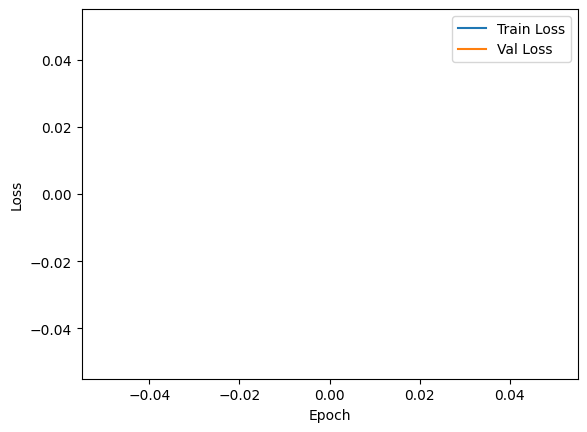

In [169]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [170]:
# save the model
torch.save(model.state_dict(), 'cnn_model.pth')

In [171]:
# # load file and check MSELoss
# model = CNNModel(num_lidar_features, num_non_lidar_features, num_actions)
# model.load_state_dict(torch.load('cnn_model.pth', map_location=torch.device('cpu')))
# model.eval()
# device = 'cpu'

# # take world idx 0 as example
# dataset = KULBarnDataset(df[df['world_idx'] == 0][df['timestep']>0], "val")
# loader = DataLoader(dataset, batch_size=1, shuffle=False)

# final_val_loss = test_model(model, loader, loss_fn)
# print("Final val loss:", final_val_loss)

In [184]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class MultiHeadAttention(nn.Module):
    def __init__(
            self,
            input_dim,
            num_heads,
            dropout=0.0,
            bias=False,
            encoder_decoder_attention=False,
            causal=False
    ):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = input_dim // num_heads
        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal
        self.k_proj = nn.Linear(input_dim, input_dim, bias=bias)
        self.v_proj = nn.Linear(input_dim, input_dim, bias=bias)
        self.q_proj = nn.Linear(input_dim, input_dim, bias=bias)
        self.out_proj = nn.Linear(input_dim, input_dim, bias=bias)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.head_dim,)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def multi_head_scaled_dot_product(self,
                                      query: torch.Tensor,
                                      key: torch.Tensor,
                                      value: torch.Tensor,
                                      attention_mask: torch.BoolTensor):
        attn_weights = torch.matmul(query, key.transpose(-1, -2) / math.sqrt(self.input_dim))
        if attention_mask is not None:
            if self.causal:
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(0).unsqueeze(1), float("-inf"))
            else:
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2), float("-inf"))
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.matmul(attn_probs, value)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_attn_output_shape = attn_output.size()[:-2] + (self.input_dim,)
        attn_output = attn_output.view(*concat_attn_output_shape)
        attn_output = self.out_proj(attn_output)
        return attn_output, attn_weights

    def forward(
            self,
            query: torch.Tensor,
            key: torch.Tensor,
            attention_mask: torch.BoolTensor):
        q = self.q_proj(query)
        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)
        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_output, attn_weights = self.multi_head_scaled_dot_product(q, k, v, attention_mask)
        return attn_output, attn_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim: int, d_ff: int, dropout: float = 0.1):
        super(PositionWiseFeedForward, self).__init__()

        self.activation = nn.ReLU()
        self.w_1 = nn.Linear(input_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, input_dim)
        self.dropout = dropout

    def forward(self, x):
        residual = x
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        return x + residual


class EmbeddingLidar(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.len_lidar = 720
        self.num_patch = config.num_patch
        self.dim_patch = self.len_lidar // self.num_patch
        self.model_dim = config.model_dim
        self.dropout = config.dropout
        self.pos_embed = nn.Parameter(torch.randn(self.num_patch, self.model_dim))

        self.linear = nn.Linear(self.dim_patch, self.model_dim)

    def forward(self, inputs):
        x = inputs.view([-1, self.num_patch, self.dim_patch])
        x = self.linear(x)
        x = x + self.pos_embed
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x


class EncoderLayer(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.input_dim = config.input_dim
        self.ffn_dim = config.ffn_dim
        self.self_attn = MultiHeadAttention(
            input_dim=self.input_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout)
        self.self_attn_layer_norm = nn.LayerNorm(self.input_dim)
        self.dropout = config.dropout
        self.activation_fn = nn.ReLU()
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.input_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.input_dim)

    def forward(self, x, encoder_padding_mask):
        residual = x
        x, attn_weights = self.self_attn(query=x, key=x, attention_mask=encoder_padding_mask)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.self_attn_layer_norm(x)
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)
        return x, attn_weights


class Encoder(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.dropout = config.dropout

        self.embedding = EmbeddingLidar(config)

        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.encoder_layers)])

    def forward(self, inputs, attention_mask=None):
        x = self.embedding(inputs)
        self_attn_scores = []
        for encoder_layer in self.layers:
            x, attn = encoder_layer(x, attention_mask)
            self_attn_scores.append(attn.detach())

        return x, self_attn_scores


class DecoderLayer(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.input_dim = config.input_dim
        self.ffn_dim = config.ffn_dim
        self.dropout = config.dropout
        self.self_attn_layer_norm = nn.LayerNorm(self.input_dim)
        self.encoder_attn = MultiHeadAttention(
            input_dim=self.input_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout,
            encoder_decoder_attention=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.input_dim)
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.input_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.input_dim)

    def forward(
            self,
            x,
            encoder_hidden_states,
            encoder_attention_mask=None,
    ):
        residual = x
        x, cross_attn_weights = self.encoder_attn(
            query=x,
            key=encoder_hidden_states,
            attention_mask=encoder_attention_mask,
        )
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.encoder_attn_layer_norm(x)
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)

        return (
            x,
            cross_attn_weights,
        )


class Decoder(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.dropout = config.dropout
        self.model_dim = config.model_dim
        self.linear = nn.Linear(1, self.model_dim)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.decoder_layers)])

    def forward(
            self,
            inputs,
            encoder_hidden_states,
    ):
        x = inputs
        x = self.linear(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        cross_attention_scores = []
        for idx, decoder_layer in enumerate(self.layers):
            x, layer_cross_attn = decoder_layer(
                x,
                encoder_hidden_states,
            )
            cross_attention_scores.append(layer_cross_attn.detach())
        return x, cross_attention_scores


class Transformer(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.model_dim = config.model_dim
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

        self.prediction_head = nn.Linear(self.model_dim * 2, 2)

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                if 'weight' in name:
                    nn.init.normal_(param.data, mean=0, std=0.01)
                else:
                    nn.init.constant_(param.data, 0)

    def forward(self, src, trg):
        encoder_output, encoder_attention_scores = self.encoder(
            inputs=src
        )
        decoder_output, decoder_attention_scores = self.decoder(
            trg,
            encoder_output
        )
        decoder_output = decoder_output.view(-1, self.model_dim * 2)
        decoder_output = self.prediction_head(decoder_output)
        
        return decoder_output, encoder_attention_scores, decoder_attention_scores

In [185]:
def train_model(model, train_loader, loss_fn, optimizer):
    model.train()

    losses = []
    for lidar, non_lidar, actions in tqdm(train_loader):
        lidar = lidar.to(device).unsqueeze(-1)
        non_lidar = non_lidar.to(device).unsqueeze(-1)
        actions = actions.to(device)

        actions_pred, _, _ = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [186]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        lidar = lidar.to(device).unsqueeze(-1)
        non_lidar = non_lidar.to(device).unsqueeze(-1)
        actions = actions.to(device)

        actions_pred, _, _ = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [189]:
import easydict

# Initialize the model
num_lidar_features = len(train_dataset.lidar_cols)
num_non_lidar_features = len(train_dataset.non_lidar_cols)
num_actions = len(train_dataset.actions_cols)

config_dict = easydict.EasyDict({
    "input_dim": 32,
    "num_patch": 36,
    "model_dim": 32,
    "ffn_dim": 256,
    "attention_heads": 4,
    "attention_dropout": 0.0,
    "dropout": 0.2,
    "encoder_layers": 3,
    "decoder_layers": 3,
    "device": device,
})

model = Transformer(config_dict)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cuda


In [190]:
import sys
NUM_EPOCHS = 100

random_val_loss = test_model(model, val_loader, loss_fn)
print("Random val loss:", random_val_loss)

transformer_train_losses = []
transformer_val_losses = []
best_val_loss = float('inf')
patience = 3
no_improve_epochs = 0

for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    val_loss = test_model(model, val_loader, loss_fn)
    transformer_train_losses.append(train_loss)
    transformer_val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {val_loss}")
    sys.stdout.flush()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping due to no improvement after {} epochs.".format(patience))
            break

100%|██████████| 310/310 [00:02<00:00, 151.59it/s]


Random val loss: 0.5685312477090666


100%|██████████| 310/310 [00:01<00:00, 211.91it/s]

Epoch 1/100 | Train Loss: 0.5571266180456174 | Val Loss: 0.5544575936130939



100%|██████████| 310/310 [00:01<00:00, 207.49it/s]

Epoch 2/100 | Train Loss: 0.546223169092493 | Val Loss: 0.5436342889022443



100%|██████████| 310/310 [00:01<00:00, 184.04it/s]

Epoch 3/100 | Train Loss: 0.5345336212797825 | Val Loss: 0.5309382210816106



100%|██████████| 310/310 [00:01<00:00, 205.52it/s]

Epoch 4/100 | Train Loss: 0.5210909432949755 | Val Loss: 0.5167696050097865



100%|██████████| 310/310 [00:01<00:00, 206.37it/s]

Epoch 5/100 | Train Loss: 0.5062515145964044 | Val Loss: 0.5012798699159776



100%|██████████| 310/310 [00:01<00:00, 206.66it/s]

Epoch 6/100 | Train Loss: 0.4901173519974094 | Val Loss: 0.4844622971550111



100%|██████████| 310/310 [00:01<00:00, 198.94it/s]

Epoch 7/100 | Train Loss: 0.4726863709382828 | Val Loss: 0.4663704291707085



100%|██████████| 310/310 [00:03<00:00, 99.81it/s] 

Epoch 8/100 | Train Loss: 0.454058450139862 | Val Loss: 0.4471225512844901



100%|██████████| 310/310 [00:01<00:00, 187.11it/s]

Epoch 9/100 | Train Loss: 0.434348737177462 | Val Loss: 0.4268349029484295



100%|██████████| 310/310 [00:01<00:00, 167.93it/s]

Epoch 10/100 | Train Loss: 0.4136613420632718 | Val Loss: 0.40564589112276034



100%|██████████| 310/310 [00:01<00:00, 198.90it/s]

Epoch 11/100 | Train Loss: 0.3921694955232476 | Val Loss: 0.38369539406511094



100%|██████████| 310/310 [00:03<00:00, 96.41it/s] 

Epoch 12/100 | Train Loss: 0.3699874845464988 | Val Loss: 0.3611260969251875



100%|██████████| 310/310 [00:01<00:00, 209.79it/s]

Epoch 13/100 | Train Loss: 0.3472682121893223 | Val Loss: 0.338102028572992



100%|██████████| 310/310 [00:01<00:00, 175.52it/s]

Epoch 14/100 | Train Loss: 0.324191743363656 | Val Loss: 0.3147743183758951



100%|██████████| 310/310 [00:01<00:00, 202.08it/s]

Epoch 15/100 | Train Loss: 0.3008927734553434 | Val Loss: 0.2913153313565999



100%|██████████| 310/310 [00:02<00:00, 135.97it/s]

Epoch 16/100 | Train Loss: 0.277548781875436 | Val Loss: 0.2678957426139424



100%|██████████| 310/310 [00:01<00:00, 193.09it/s]

Epoch 17/100 | Train Loss: 0.25435581329934903 | Val Loss: 0.244716787131338



100%|██████████| 310/310 [00:02<00:00, 141.50it/s]

Epoch 18/100 | Train Loss: 0.23149409199451032 | Val Loss: 0.22196072386127086



100%|██████████| 310/310 [00:02<00:00, 126.16it/s]

Epoch 19/100 | Train Loss: 0.2091575792651885 | Val Loss: 0.19981017119641747



100%|██████████| 310/310 [00:02<00:00, 132.76it/s]

Epoch 20/100 | Train Loss: 0.1875393302090731 | Val Loss: 0.1784811276777257



100%|██████████| 310/310 [00:02<00:00, 132.18it/s]

Epoch 21/100 | Train Loss: 0.1668322328325283 | Val Loss: 0.15815233665428335



100%|██████████| 310/310 [00:02<00:00, 108.48it/s]

Epoch 22/100 | Train Loss: 0.1472331070211277 | Val Loss: 0.13902694925125086



100%|██████████| 310/310 [00:02<00:00, 130.20it/s]

Epoch 23/100 | Train Loss: 0.12895436273546468 | Val Loss: 0.12132086419470368



100%|██████████| 310/310 [00:02<00:00, 139.54it/s]

Epoch 24/100 | Train Loss: 0.11216669325583505 | Val Loss: 0.10517288178145405



100%|██████████| 310/310 [00:02<00:00, 126.84it/s]

Epoch 25/100 | Train Loss: 0.09700846808912435 | Val Loss: 0.0906854853875214



100%|██████████| 310/310 [00:02<00:00, 120.37it/s]

Epoch 26/100 | Train Loss: 0.08344462177730629 | Val Loss: 0.07766112935759367



100%|██████████| 310/310 [00:02<00:00, 127.87it/s]

Epoch 27/100 | Train Loss: 0.07111285967495948 | Val Loss: 0.06566082717279993



100%|██████████| 310/310 [00:02<00:00, 126.17it/s]

Epoch 28/100 | Train Loss: 0.05979400722746319 | Val Loss: 0.05473839721432136



100%|██████████| 310/310 [00:02<00:00, 137.24it/s]

Epoch 29/100 | Train Loss: 0.04964736583341276 | Val Loss: 0.04504664226795637



100%|██████████| 310/310 [00:02<00:00, 122.29it/s]

Epoch 30/100 | Train Loss: 0.04055516290119293 | Val Loss: 0.03585734518410097



100%|██████████| 310/310 [00:02<00:00, 131.72it/s]

Epoch 31/100 | Train Loss: 0.031902045543825995 | Val Loss: 0.027665094885554527



100%|██████████| 310/310 [00:02<00:00, 144.51it/s]

Epoch 32/100 | Train Loss: 0.024535633582849336 | Val Loss: 0.02083181269737261



100%|██████████| 310/310 [00:02<00:00, 123.93it/s]

Epoch 33/100 | Train Loss: 0.01869777583881343 | Val Loss: 0.015866973090376105



100%|██████████| 310/310 [00:03<00:00, 102.13it/s]

Epoch 34/100 | Train Loss: 0.014461719430346338 | Val Loss: 0.012376576863349446



100%|██████████| 310/310 [00:02<00:00, 130.48it/s]

Epoch 35/100 | Train Loss: 0.011668525422255126 | Val Loss: 0.010183095237270238



100%|██████████| 310/310 [00:02<00:00, 118.33it/s]

Epoch 36/100 | Train Loss: 0.01010360364117061 | Val Loss: 0.00913344681781206



100%|██████████| 310/310 [00:02<00:00, 117.43it/s]

Epoch 37/100 | Train Loss: 0.00936526662800393 | Val Loss: 0.008471554200326453



100%|██████████| 310/310 [00:03<00:00, 97.20it/s] 

Epoch 38/100 | Train Loss: 0.008947824101866229 | Val Loss: 0.008370586726889616



100%|██████████| 310/310 [00:01<00:00, 190.96it/s]

Epoch 39/100 | Train Loss: 0.008605364640795183 | Val Loss: 0.008191030008874218



100%|██████████| 310/310 [00:01<00:00, 187.56it/s]

Epoch 40/100 | Train Loss: 0.008271505111760953 | Val Loss: 0.007956614533383888



100%|██████████| 310/310 [00:01<00:00, 184.81it/s]

Epoch 41/100 | Train Loss: 0.007905516472926115 | Val Loss: 0.007715382820676877



100%|██████████| 310/310 [00:01<00:00, 191.65it/s]

Epoch 42/100 | Train Loss: 0.007429931224028791 | Val Loss: 0.007098943401374967



100%|██████████| 310/310 [00:01<00:00, 192.66it/s]

Epoch 43/100 | Train Loss: 0.006918433705315506 | Val Loss: 0.00715696982582402



100%|██████████| 310/310 [00:01<00:00, 193.66it/s]

Epoch 44/100 | Train Loss: 0.006492847493166696 | Val Loss: 0.005917869533679491



100%|██████████| 310/310 [00:01<00:00, 206.66it/s]

Epoch 45/100 | Train Loss: 0.0061877408361936 | Val Loss: 0.006083793143549091



100%|██████████| 310/310 [00:01<00:00, 165.16it/s]

Epoch 46/100 | Train Loss: 0.005963563540903299 | Val Loss: 0.0057814523354365165



100%|██████████| 310/310 [00:02<00:00, 147.15it/s]

Epoch 47/100 | Train Loss: 0.005788303262275221 | Val Loss: 0.006041371849395575



100%|██████████| 310/310 [00:01<00:00, 188.48it/s]

Epoch 48/100 | Train Loss: 0.005652192352501355 | Val Loss: 0.005862352345074244



100%|██████████| 310/310 [00:01<00:00, 193.81it/s]

Epoch 49/100 | Train Loss: 0.0055573889345767735 | Val Loss: 0.00562046864075866



100%|██████████| 310/310 [00:02<00:00, 108.20it/s]

Epoch 50/100 | Train Loss: 0.005478517849322191 | Val Loss: 0.0053847676450870146



100%|██████████| 310/310 [00:02<00:00, 108.16it/s]

Epoch 51/100 | Train Loss: 0.005390919240678889 | Val Loss: 0.0054418300911141075



100%|██████████| 310/310 [00:02<00:00, 106.34it/s]

Epoch 52/100 | Train Loss: 0.0053594393523854825 | Val Loss: 0.0058605946217275846



100%|██████████| 310/310 [00:02<00:00, 123.03it/s]

Epoch 53/100 | Train Loss: 0.005302370164764972 | Val Loss: 0.005795082320459656
Early stopping due to no improvement after 3 epochs.


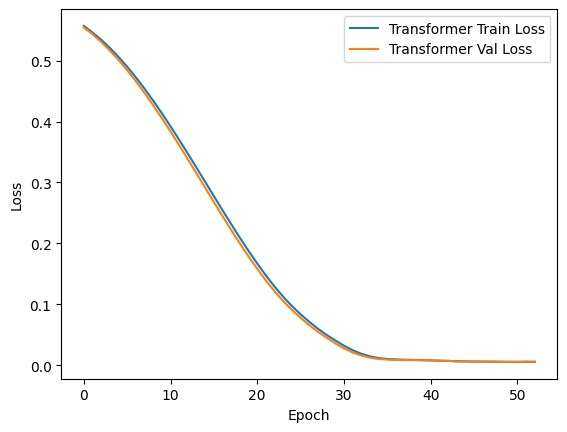

In [191]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(transformer_train_losses, label='Transformer Train Loss')  
plt.plot(transformer_val_losses, label='Transformer Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [192]:
# save the model
torch.save(model.state_dict(), 'transformer_model.pth')

In [200]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device).unsqueeze(-1)
        non_lidar = non_lidar.to(device).unsqueeze(-1)
        actions = actions.to(device)

        # Forward pass
        actions_pred, _, _ = model(lidar.float(), non_lidar.float())        
        loss = loss_fn(actions_pred, actions.float())

        print(non_lidar)
        print(actions_pred)
        print(actions)
        print(loss)

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [201]:
# load file and check MSELoss
config_dict = easydict.EasyDict({
    "input_dim": 32,
    "num_patch": 36,
    "model_dim": 32,
    "ffn_dim": 256,
    "attention_heads": 4,
    "attention_dropout": 0.0,
    "dropout": 0.2,
    "encoder_layers": 3,
    "decoder_layers": 3,
    "device": device,
})

model = Transformer(config_dict)
model.load_state_dict(torch.load('transformer_model.pth', map_location=torch.device('cpu')))
model.eval()
device = 'cpu'

# take world idx 0 as example
dataset = KULBarnDataset(df[df['world_idx'] == 0], "val")
print(len(dataset))
loader = DataLoader(dataset, batch_size=64, shuffle=False)

final_val_loss = test_model(model, loader, loss_fn)
print("Final val loss:", final_val_loss)

665


  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 35.67it/s]

tensor([[[0.9949],
         [0.5713]],

        [[0.9949],
         [0.5713]],

        [[0.9949],
         [0.5713]],

        [[0.9949],
         [0.5715]],

        [[0.9948],
         [0.5719]],

        [[0.9948],
         [0.5721]],

        [[0.9947],
         [0.5724]],

        [[0.9947],
         [0.5728]],

        [[0.9946],
         [0.5732]],

        [[0.9946],
         [0.5736]],

        [[0.9945],
         [0.5740]],

        [[0.9944],
         [0.5745]],

        [[0.9943],
         [0.5750]],

        [[0.9943],
         [0.5755]],

        [[0.9950],
         [0.5707]],

        [[0.9949],
         [0.5712]],

        [[0.9948],
         [0.5717]],

        [[0.9948],
         [0.5722]],

        [[0.9947],
         [0.5728]],

        [[0.9946],
         [0.5734]],

        [[0.9945],
         [0.5740]],

        [[0.9944],
         [0.5747]],

        [[0.9951],
         [0.5699]],

        [[0.9950],
         [0.5704]],

        [[0.9949],
         [0.5710]],



100%|██████████| 11/11 [00:00<00:00, 39.25it/s]

tensor([[0.9414, 0.5459],
        [0.9352, 0.5461],
        [0.9316, 0.5446],
        [0.9272, 0.5444],
        [0.9303, 0.5441],
        [0.9290, 0.5617],
        [0.9599, 0.5567],
        [0.9620, 0.5546],
        [0.9587, 0.5548],
        [0.9541, 0.5556],
        [0.9546, 0.5534],
        [0.9509, 0.5535],
        [0.9511, 0.5517],
        [0.9528, 0.5510],
        [0.9580, 0.5497],
        [0.9577, 0.5494],
        [0.9539, 0.5499],
        [0.9485, 0.5486],
        [0.9791, 0.5400],
        [0.9843, 0.5374],
        [0.9801, 0.5369],
        [0.9800, 0.5369],
        [0.9769, 0.5361],
        [0.9810, 0.5333],
        [0.9791, 0.5342],
        [0.9875, 0.5470],
        [0.9893, 0.5459],
        [0.9905, 0.5445],
        [0.9881, 0.5454],
        [0.9993, 0.5370],
        [0.9993, 0.5345],
        [1.0005, 0.5325],
        [0.9993, 0.5313],
        [0.9990, 0.5313],
        [0.9959, 0.5340],
        [0.9967, 0.5306],
        [0.9995, 0.5271],
        [0.9992, 0.5268],
        [0.9

In [ ]:
import os
import hydra
import torch
from omegaconf import OmegaConf
import pathlib
from torch.utils.data import DataLoader
import copy
import numpy as np
import random
import wandb
import tqdm
import shutil
from diffusion_policy.policy.diffusion_unet_lowdim_policy import DiffusionUnetLowdimPolicy
from diffusion_policy.workspace.train_diffusion_unet_lowdim_workspace import TrainDiffusionUnetLowdimWorkspace
import os

ModuleNotFoundError: No module named 'hydra'

In [ ]:
from diffusion_policy.dataset.base_dataset import BaseLowdimDataset
from typing import Dict
import torch
import numpy as np
import copy
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.common.replay_buffer import ReplayBuffer
from diffusion_policy.common.sampler import (
    SequenceSampler, get_val_mask, downsample_mask)
from diffusion_policy.model.common.normalizer import LinearNormalizer
from diffusion_policy.dataset.base_dataset import BaseLowdimDataset


class KULBarnDiffusionDataset(BaseLowdimDataset):
    def __init__(self, df, horizon=4):
        super().__init__()
        
        self.data = df
        self.get_local_goal()

        self.data = self.data.drop(columns=[
            'timestep', 'actual_time', 'optimal_time', 
            'pos_x', 'pos_y', 'pose_heading', 'goal_x', 'goal_y', 'success'
        ])
        
        self.data = pd.DataFrame(self.data, columns=self.data.columns)
        self.horizon = horizon

        # Process data columns
        self.lidar_cols = [col for col in self.data.columns if 'lidar' in col]
        self.actions_cols = [col for col in self.data.columns if 'cmd' in col]
        self.non_lidar_cols = [col for col in self.data.columns if col not in self.lidar_cols and col not in self.actions_cols and col != 'world_idx']

        self.lidar_data = self.data[self.lidar_cols].values
        self.non_lidar_data = self.data[self.non_lidar_cols].values
        self.actions_data = self.data[self.actions_cols].values

        print("Lidar Columns:", self.lidar_cols)
        print("Non Lidar Columns:", self.non_lidar_cols)
        print("Action Columns:", self.actions_cols)     

        self.grouped_data = self.data.groupby(self.data['world_idx'])
        self.horizon = horizon
        path_lengths = [len(group) for name, group in self.grouped_data]
        self.indices = self.make_indices(path_lengths, horizon)

    def get_local_goal(self):
        x = self.data['pos_x']
        y = self.data['pos_y']
        theta = self.data['pose_heading']
        goal_x = self.data['goal_x']
        goal_y = self.data['goal_y']
        self.data['local_x'] = (goal_x - x) * np.cos(theta) + (goal_y - y) * np.sin(theta)
        self.data['local_y'] = -(goal_x - x) * np.sin(theta) + (goal_y - y) * np.cos(theta)

    def make_indices(self, path_lengths, horizon):
        indices = []
        for i, path_length in enumerate(path_lengths):
            max_start = path_length - horizon
            for start in range(max_start):
                end = start + horizon
                indices.append((i, start, end))
        indices = np.array(indices)
        return indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        idx = self.indices[idx]
        start = idx[1]
        end = idx[2]

        data = {
            'obs': self.lidar_data[start:end],
            'cond': self.non_lidar_data[start:end],
            'action': self.actions_data[start:end],
        }
        torch_data = dict_apply(data, torch.from_numpy)
        return torch_data

    def get_normalizer(self, mode='limits', **kwargs):
        normalizer = LinearNormalizer()
        # train it in using self.data as a dictionary
        data_dict = {
            'obs': self.lidar_data,
            'cond': self.non_lidar_data,
            'action': self.actions_data
        }
        normalizer.fit(data=data_dict, mode=mode, **kwargs)
        return normalizer

    def get_all_actions(self) -> torch.Tensor:
        return torch.from_numpy(self.actions_data)

ModuleNotFoundError: No module named 'diffusion_policy.dataset'

In [ ]:
train_dataset = KULBarnDiffusionDataset(train_df)
train_dataloader = DataLoader(train_dataset)
normalizer = train_dataset.get_normalizer()
print(len(train_dataloader))

Lidar Columns: ['lidar_0', 'lidar_1', 'lidar_2', 'lidar_3', 'lidar_4', 'lidar_5', 'lidar_6', 'lidar_7', 'lidar_8', 'lidar_9', 'lidar_10', 'lidar_11', 'lidar_12', 'lidar_13', 'lidar_14', 'lidar_15', 'lidar_16', 'lidar_17', 'lidar_18', 'lidar_19', 'lidar_20', 'lidar_21', 'lidar_22', 'lidar_23', 'lidar_24', 'lidar_25', 'lidar_26', 'lidar_27', 'lidar_28', 'lidar_29', 'lidar_30', 'lidar_31', 'lidar_32', 'lidar_33', 'lidar_34', 'lidar_35', 'lidar_36', 'lidar_37', 'lidar_38', 'lidar_39', 'lidar_40', 'lidar_41', 'lidar_42', 'lidar_43', 'lidar_44', 'lidar_45', 'lidar_46', 'lidar_47', 'lidar_48', 'lidar_49', 'lidar_50', 'lidar_51', 'lidar_52', 'lidar_53', 'lidar_54', 'lidar_55', 'lidar_56', 'lidar_57', 'lidar_58', 'lidar_59', 'lidar_60', 'lidar_61', 'lidar_62', 'lidar_63', 'lidar_64', 'lidar_65', 'lidar_66', 'lidar_67', 'lidar_68', 'lidar_69', 'lidar_70', 'lidar_71', 'lidar_72', 'lidar_73', 'lidar_74', 'lidar_75', 'lidar_76', 'lidar_77', 'lidar_78', 'lidar_79', 'lidar_80', 'lidar_81', 'lidar_82'

In [ ]:
for batch in train_dataloader:
    # print(batch)
    print(batch['obs'].shape)
    print(batch['cond'].shape)
    print(batch['action'].shape)
    break

torch.Size([1, 4, 720])
torch.Size([1, 4, 4])
torch.Size([1, 4, 2])


In [ ]:
from diffusion_policy.policy.diffusion_unet_lidar_policy import DiffusionUnetLidarPolicy
from diffusion_policy.model.diffusion.conditional_unet1d import ConditionalUnet1D
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler

obs_dim = batch['obs'].shape[-1]
action_dim = batch['action'].shape[-1]
input_dim = obs_dim + action_dim
model = ConditionalUnet1D(input_dim=input_dim)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='linear')
horizon = 4
policy = DiffusionUnetLidarPolicy(
    model=model, 
    noise_scheduler=noise_scheduler, 
    horizon=horizon, 
    obs_dim=obs_dim, 
    action_dim=action_dim, 
    n_obs_steps=4,
    n_action_steps=4,
    pred_action_steps_only=False,
)

In [ ]:
policy.set_normalizer(normalizer)

In [ ]:
from tqdm import tqdm

NUM_EPOCHS = 10
losses = []
save_loss_every = 1000
total_loss = 0
count = 0

optimizer = optim.Adam(policy.model.parameters(), lr=5e-5)
policy.model.train()
for epoch in range(NUM_EPOCHS):
    for batch in tqdm(train_dataloader):
        loss = policy.compute_loss(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        count += 1
        if count >= save_loss_every:
            curr_loss = total_loss / save_loss_every
            print("Loss:", curr_loss)
            losses.append(curr_loss)
            total_loss = 0
            count = 0

  0%|          | 0/141127 [00:00<?, ?it/s]


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

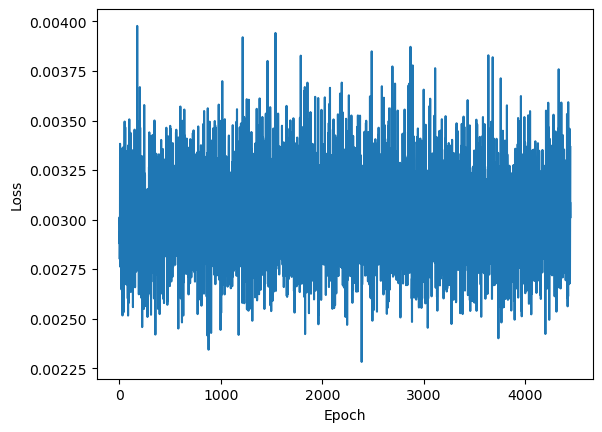

In [ ]:
# plot loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();